In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_7/CE/'
VIDEO_DIR=DATA_DIR+'videos/'
FRAMES_DIR=DATA_DIR+'frames/'
FACES_DIR=DATA_DIR+'faces/'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

# Extract frames

In [10]:
for filename in tqdm(os.listdir(VIDEO_DIR)):
    frames_dir=FRAMES_DIR + str(os.path.splitext(filename)[0])
    if not os.path.exists(frames_dir):
        os.mkdir(frames_dir)
    command = "ffmpeg -r 1 -i " + VIDEO_DIR + str(filename) + " -r 1 '" + frames_dir + "/%04d.png'"
    #print(command)
    os.system(command=command)

100%|██████████| 57/57 [01:47<00:00,  1.88s/it]


In [21]:
video2len={}
for filename in sorted(os.listdir(VIDEO_DIR)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    vid=os.path.join(VIDEO_DIR,filename)
    cap = cv2.VideoCapture(vid)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video2len[fn]=total_frames #+1 #FIX ME!!! NEED TO ADD 1 to teh number of frames for consistency with challeng's organizer
    
    dn=os.path.join(FRAMES_DIR,fn)
    last_img=''
    if os.path.exists(dn):
        images=[img_name for img_name in os.listdir(dn) if img_name.lower().endswith('.png')]
        last_img=sorted(images, key=compare_filenames)[-1]
    if True or str(total_frames) not in last_img:
        print(fn,total_frames,last_img)

01 659 0659.png
02 278 0278.png
03 302 0302.png
04 1204 1204.png
05 188 0188.png
06 61 0061.png
07 128 0128.png
08 302 0302.png
09 91 0087.png
10 36 0035.png
11 228 0228.png
12 444 0444.png
13 69 0069.png
14 5459 5459.png
15 786 0786.png
16 265 0265.png
17 67 0067.png
18 282 0282.png
19 255 0255.png
20 205 0205.png
21 377 0377.png
22 69 0068.png
23 66 0066.png
24 660 0626.png
25 266 0266.png
26 2438 2438.png
27 56 0056.png
28 329 0329.png
29 91 0091.png
30 72 0072.png
31 773 0773.png
32 412 0412.png
33 192 0192.png
34 56 0056.png
35 196 0196.png
36 577 0577.png
37 154 0154.png
38 703 0703.png
39 495 0495.png
40 768 0768.png
41 319 0319.png
42 563 0563.png
43 75 0075.png
44 386 0386.png
45 62 0061.png
46 352 0352.png
47 180 0180.png
48 104 0104.png
49 597 0597.png
50 273 0273.png
51 482 0482.png
52 76 0076.png
53 442 0442.png
54 478 0478.png
55 1465 1465.png
56 266 0266.png


# Detect faces

In [6]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh=mp_face_mesh.FaceMesh(max_num_faces=1,refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5)

In [20]:
from retinaface.pre_trained_models import get_model
model = get_model("resnet50_2020-07-20", max_size=1024,device='cuda')
model.eval()

In [10]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

In [26]:
if not os.path.exists(FACES_DIR):
    os.mkdir(FACES_DIR)
for folder in tqdm(os.listdir(FRAMES_DIR)):
    folder_full_path=os.path.join(FACES_DIR, folder)
    if not os.path.exists(folder_full_path):
        os.mkdir(folder_full_path)

        for image_file in os.listdir(os.path.join(FRAMES_DIR, folder)):
            filename = os.path.join(FRAMES_DIR, folder, image_file)
            image = cv2.imread(filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            annotations = model.predict_jsons(image_rgb)
            if len(annotations)==0 or not annotations[0]["bbox"]:
                pass #print('No faces')
            else:
                root,ext=os.path.splitext(image_file)
                faces_folder=os.path.join(folder_full_path, root) 
                if not os.path.exists(faces_folder):
                    os.mkdir(faces_folder)
                for i,annotation in enumerate(annotations):
                    outfile=os.path.join(faces_folder, str(i)+ext)
                    if not os.path.exists(outfile):
                        box = np.array(annotation['bbox']).astype(int)
                        x1,y1,x2,y2=box[0:4]    
                        x1=max(x1,0)
                        y1=max(y1,0)
                        face_img=image[y1:y2,x1:x2,:]
                        if np.prod(face_img.shape)==0:
                            print('Empty face ', x1,x2,y1,y2,folder,image_file)
                            continue
                        cv2.imwrite(outfile, face_img) 

100%|██████████| 56/56 [33:27<00:00, 35.85s/it] 


In [ ]:
if not os.path.exists(FACES_DIR):
    os.mkdir(FACES_DIR)
for folder in tqdm(os.listdir(FRAMES_DIR)):
    folder_full_path=os.path.join(FACES_DIR, folder)
    if not os.path.exists(folder_full_path):
        os.mkdir(folder_full_path)

        for image_file in os.listdir(os.path.join(FRAMES_DIR, folder)):
            filename = os.path.join(FRAMES_DIR, folder, image_file)
            image = cv2.imread(filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            results = face_mesh.process(image_rgb)
            if results.multi_face_landmarks:
                height,width,_=image.shape
                for face_landmarks in results.multi_face_landmarks:
                    x1 = y1 = 1
                    x2 = y2 = 0
                    for id, lm in enumerate(face_landmarks.landmark):
                        cx, cy = lm.x, lm.y
                        if cx<x1:
                            x1=cx
                        if cy<y1:
                            y1=cy
                        if cx>x2:
                            x2=cx
                        if cy>y2:
                            y2=cy
                    if x1<0:
                        x1=0
                    if y1<0:
                        y1=0
                    x1,x2=int(x1*width),int(x2*width)
                    y1,y2=int(y1*height),int(y2*height)
                    face_img=image_rgb[y1:y2,x1:x2,:]
                    if np.prod(face_img.shape)==0:
                        print('Empty face ', x1,x2,y1,y2,folder,image_file)
                        continue
                    cv2.imwrite(os.path.join(folder_full_path, image_file), face_img) 

In [27]:
for folder in sorted(os.listdir(FACES_DIR)):
    print(folder, len(os.listdir(os.path.join(FACES_DIR, folder))), len(os.listdir(os.path.join(FRAMES_DIR, folder))))

01 644 659
02 157 278
03 302 302
04 1094 1204
05 188 188
06 48 61
07 128 128
08 302 302
09 35 87
10 33 35
11 215 228
12 431 444
13 69 69
14 5315 5459
15 476 786
16 265 265
17 61 67
18 175 282
19 99 255
20 205 205
21 312 377
22 56 68
23 66 66
24 421 626
25 266 266
26 1989 2438
27 56 56
28 234 329
29 91 91
30 70 72
31 770 773
32 412 412
33 192 192
34 56 56
35 196 196
36 577 577
37 144 154
38 669 703
39 384 495
40 432 768
41 203 319
42 434 563
43 63 75
44 378 386
45 61 61
46 352 352
47 38 180
48 102 104
49 592 597
50 234 273
51 482 482
52 75 76
53 334 442
54 344 478
55 1097 1465
56 217 266


# Extract features

In [6]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [7]:
#num_classes=7
if True:
    #PATH='affectnet_vggface2_enet2_gmp_smooth.pt'
    PATH='enet_b2_8_best.pt'
    #PATH='enet_b2_7.pt'
    IMG_SIZE=260 #224 #
else:
    #PATH='affectnet_vggface2_enet0.pt'
    #PATH='affectnet_vggface2_enet0_new.pt'
    #PATH='enet_b0_7.pt'
    #PATH='enet_b0_8_best_afew.pt'
    PATH='enet_b0_8_best_vgaf.pt'
    #PATH='enet_b0_8_va_mtl.pt'
    #PATH='affectnet_vggface2_mobilevit_mtl_new.pt'
    
    IMG_SIZE=224
    
#IMG_SIZE=112

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
np_transforms = transforms.Compose(
    [
        transforms.ToPILImage(None),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)


In [7]:
if False:
    PATH='affectnet_vggface2_mbf_va.pt'
    
    IMG_SIZE=112
    
    test_transforms = transforms.Compose(
    [
        transforms.Resize((112,112)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
    ]
    )
    
    import sys
    sys.path.append("/home/avsavchenko/src/distr/insightface/recognition/arcface_torch/backbones/")
    import mobilefacenet

In [8]:
print(PATH)
feature_extractor_model = torch.load('/home/avsavchenko/src/face-emotion-recognition/models/affectnet_emotions/'+PATH)

enet_b2_8_best.pt


In [35]:
if True:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if True:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    

In [37]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(8, 512) [[-0.02266632  0.03422606  0.04598025 ... -0.03784892 -0.02933266
  -0.02419638]
 [-0.06048942 -0.01143544  0.04876871 ... -0.00673319 -0.03489853
  -0.04350665]
 [ 0.00924769  0.01705422 -0.02023846 ... -0.04731875 -0.04449094
   0.01527624]
 ...
 [ 0.02578277  0.02344748  0.02957167 ...  0.03510113  0.03270051
  -0.02460761]
 [ 0.02018657 -0.03497695  0.01600289 ...  0.04777396  0.01695777
  -0.00137146]
 [ 0.01643609  0.00521718 -0.01940052 ...  0.0298525  -0.028677
   0.04591733]]
(8,) [ 0.0492584  -0.05201729 -0.02789966 -0.06214872 -0.05696991  0.05707647
 -0.00724991 -0.0286497 ]


In [38]:
if False:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

DDAMNet(
  (features): Sequential(
    (0): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (1): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (2): Mix_Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): MDConv(
        (mixed_depthwise_conv): ModuleList(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    

In [12]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

In [39]:
print(test_transforms)
data_dir=FACES_DIR
print(data_dir)

videoname2featuresAll={}
for videoname in tqdm(os.listdir(data_dir)):
    frames_dir=os.path.join(data_dir,videoname)
    X_global_features,X_global_scores,img_names=[],[],[]
    for filename in sorted(os.listdir(frames_dir)):
        faces_dir=os.path.join(frames_dir,filename)
        imgs=[]
        global_features=[]
        for img_name in sorted(os.listdir(faces_dir)):
            img = Image.open(os.path.join(faces_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                imgs.append(img_tensor)


        if len(imgs)>0:        
            if False:
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            else: #DDAMNet
                features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            features=features.data.cpu().numpy()

            scores=get_probab(features)
            #print(features.shape,scores.shape)

            #print(videoname,filename,features.shape)
            X_global_features.append(features)
            X_global_scores.append(scores)
            img_names.append(videoname+'/'+filename+'/'+img_name)

    #print(videoname,len(X_global_features))
    videoname2featuresAll[videoname]=(X_global_features,X_global_scores,img_names)

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/CE/faces/


  0%|          | 0/56 [00:00<?, ?it/s]

## Pretrained on AffWild 

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
#from tensorflow.keras.applications import efficientnet as enet
import efficientnet.tfkeras as enet
#from tensorflow.keras.utils.generic_utils import CustomObjectScope
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.13.1


In [7]:
idx_to_class_2={0: 'Neutral', 1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised', 7:'Other'} #ABAW
print(idx_to_class_2)

{0: 'Neutral', 1: 'Angry', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Sad', 6: 'Surprised', 7: 'Other'}


### ABAW (Expr) Pretraining 

In [109]:
model_name='enet_b0_8_best_vgaf'
#model_name='mobilevit_mtl'
#model_name='mbf_va'

#model_name='ddamfnet_8' #affectnet8_epoch4_acc0.6462
#model_name='ddamfnet_8_mtl' #affectnet8_epoch6_acc0

#model_name='enet_b0_8_va_mtl'
#filename=model_name+'_aligned_112.pickle'
filename=model_name+'_cropped.pickle' 
with open(filename, 'rb') as handle:
    filename2featuresAll=pickle.load(handle)
print(filename,len(filename2featuresAll))

../abaw5/enet_b0_8_best_vgaf_cropped.pickle 2942996


In [110]:
def get_image2Expr(dirname):
    dirpath=os.path.join(DATA_DIR,'../../ABAW_5/VA_AU_FER/EXPR_Classification_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)-1
                        if expression>=0 and expression<=5: #w/o neutral/ & other
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][0])
                                #X.append(filename2featuresAll[imagename][1])
                                y.append(expression)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2Expr('Train_Set')
X_val,y_val=get_image2Expr('Validation_Set')
TRAIN_VAL=False
batch_size=256 #128

(242253, 1280) (242253,) 4994
(91830, 1280) (91830,) 965


In [133]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(334083, 1280) (334083,)


In [134]:
def print_expr(X=X_val,y=y_val):
    y_val_preds=mlpModel.predict(X,verbose=0)
    y_pred=np.argmax(y_val_preds,axis=1)
    print('Acc:',(y_pred==y).mean(), 'F1:',f1_score(y_true=y,y_pred=y_pred, average="macro"))

In [135]:
(unique, counts) = np.unique(y_train, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print(np.unique(y_val, return_counts=True))

[ 22699  16067  17488 129974 103908  43947] {0: 5.725979118022821, 1: 8.089500217837806, 2: 7.432182067703569, 3: 1.0, 4: 1.2508565269276668, 5: 2.9575170091246274} 6 [0 1 2 3 4 5]
(array([0, 1, 2, 3, 4, 5]), array([ 6126,  5296,  8408, 34511, 25157, 12332]))


In [113]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

#### Multi-class classification 

In [136]:
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(num_classes, input_shape=X_val.shape[1:],activation='softmax',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_val.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(num_classes,activation='softmax'))

In [137]:
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlpModel.summary()

save_best_model = SaveBestModel('val_accuracy',True)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 10, verbose=1, shuffle=True,
             callbacks=[save_best_model], validation_data=(X_val,y_val),class_weight=class_weights)
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 128)               163968    
                                                                 
 dense_35 (Dense)            (None, 6)                 774       
                                                                 
Total params: 164742 (643.52 KB)
Trainable params: 164742 (643.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
653/653 [==============================] - 5s 7ms/step - loss: 0.9591 - accuracy: 0.8532 - val_loss: 0.2639 - val_accuracy: 0.9038
0.9038223028182983


In [116]:
if True:
    print_expr()
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
print_expr()

Acc: 0.5852880322334749 F1: 0.455170840873927
Best weights:
Acc: 0.5858434062942394 F1: 0.46569501512453515


In [170]:
if False:
    mlpModel.save_weights('abaw_expr_enet0_multiclass.h5')
else:
    mlpModel.load_weights('abaw_expr_enet0_multiclass.h5') #0.46569501512453515
    print_expr()

Acc: 0.5858434062942394 F1: 0.46569501512453515


In [175]:
if False:
    mlpModel.save_weights('abaw_expr_enet0_multiclass_train_val.h5')
else:
    mlpModel.load_weights('abaw_expr_enet0_multiclass_train_val.h5')

#### Multi-label classification

In [119]:
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes = num_classes)
y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)
print(y_train_ohe.shape,y_train_ohe[:10])

(242253, 6) [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [120]:
num_labels=num_classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = np.empty([num_labels, 2])
for i in range(num_labels):
    neg, pos = np.bincount(y_train_ohe[:, i].astype('int64'))
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weights[i][0]=weight_for_0
    class_weights[i][1]=weight_for_1
    #class_weights[i] = compute_class_weight('balanced', [0,1], y_train[:, i])
print(class_weights)

[[ 0.53671792  7.3086647 ]
 [ 0.52326531 11.24561322]
 [ 0.51947052 13.33992291]
 [ 0.82516861  1.2688319 ]
 [ 0.7408258   1.53809475]
 [ 0.57504581  3.83129843]]


In [121]:
if False:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [122]:
metrics=[tf.keras.metrics.AUC(multi_label=True,name='auc'), tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()] # 

In [127]:
batch_size=512 #256 #128
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(y_train_ohe.shape[1], input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_val.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(y_val_ohe.shape[1],activation='sigmoid'))

In [128]:
import gc
gc.collect()

2345

In [129]:
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=loss, metrics=metrics)
mlpModel.summary()

mlpModel.fit(X_train,y_train_ohe, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_val,y_val_ohe))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               163968    
                                                                 
 dense_33 (Dense)            (None, 6)                 774       
                                                                 
Total params: 164742 (643.52 KB)
Trainable params: 164742 (643.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
474/474 [==============================] - 5s 9ms/step - loss: 0.1904 - auc: 0.8692 - binary_accuracy: 0.9037 - recall_6: 0.8211 - precision_6: 0.6731 - val_loss: 1.4112 - val_auc: 0.8028 - val_binary_accuracy: 0.8447 - val_recall_6: 0.6005 - val_precision_6: 0.5302
Epoch 2/10
474/474 [==============================] - 4s 8ms/step - loss: 0.0979 - auc: 0.9931 - binary_accuracy: 0.9589 - recall_6

In [130]:
print_expr()

Acc: 0.5903844059675487 F1: 0.4695959401981484


In [155]:
if False:
    mlpModel.save_weights('abaw_expr_enet0_multilabel.h5')
else:
    mlpModel.load_weights('abaw_expr_enet0_multilabel.h5') #0.4695959401981484
    print_expr()

Acc: 0.5903844059675487 F1: 0.4695959401981484


enet_b0_8_best_vgaf
multi-class Acc: 0.5851682456713493 F1: 0.4560254761987716
Acc: 0.5858434062942394 F1: 0.46569501512453515

multilabel Acc: 0.5894152237830774 F1: 0.46974224583460283

enet_b0_8_va_mtl
multi-class Acc: 0.487411521289339 F1: 0.4111396717716926
Best weights:
Acc: 0.47348361102036374 F1: 0.3982023451444861

multilabel Acc: 0.49060219971686814 F1: 0.3890066877800855


mbf_va
multi-class Acc: 0.5362299901992813 F1: 0.3968220476090418
multilabel Acc: 0.5545573342045084 F1: 0.42504772768905436

ddamfnet_8_mtl
multi-class Acc: 0.5549820320156812 F1: 0.3933065366566983
multilabel Acc: 0.5486333442230208 F1: 0.4211318191092324


ddamfnet_8
multi-class Acc: 0.5349776761406948 F1: 0.39622075130922846
multilabel Acc: 0.5080910377872155 F1: 0.3586924049357983

mobilevit_mtl
multi-class Acc: 0.5735162800827617 F1: 0.4346964998861715
multilabel Acc: 0.571588805401285 F1: 0.4210486097188926

### To C-EXPR (expr classes)

In [176]:
MODEL2FEATURES='cexpr_enet_b0_8_best_vgaf.pickle'
with open(MODEL2FEATURES, 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
print(len(videoname2featuresAll))

56


In [141]:
idx_to_class_2={1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised'} #ABAW
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprised'} #AffectNet
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
for idx,cls in idx_to_class_2.items():
    print(idx,cls,class_to_idx[cls] if cls in class_to_idx else 'None')
    

1 Angry 0
2 Disgust 2
3 Fear 3
4 Happy 4
5 Sad 6
6 Surprised 7


In [151]:
AFFWILD2AFFECTNET=np.array([0,2,3,4,6,7])
AFFECTNET2AFFWILD={affwild:affectnet for affectnet,affwild in enumerate(AFFWILD2AFFECTNET)}
#AFFECTNET2AFFWILD=np.array([AFFECTNET2AFFWILD[i] for i in range(len(AFFWILD2AFFECTNET))])
print(AFFECTNET2AFFWILD)

{0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5}


In [177]:
for videoname in tqdm(videoname2featuresAll):
    X_global_features,_,img_names=videoname2featuresAll[videoname]
    X_global_scores=[]
    for frame_number in range(len(img_names)):
        features=X_global_features[frame_number]
        scores=mlpModel.predict(features,verbose=0)
        new_scores=np.zeros((len(scores),8))
        new_scores[:,AFFWILD2AFFECTNET]=scores

        #print(new_scores)
        X_global_scores.append(new_scores)
    videoname2featuresAll[videoname]=(X_global_features,X_global_scores,img_names)

100%|██████████| 56/56 [16:54<00:00, 18.11s/it]


In [163]:
new_scores=np.zeros((len(scores),8))
for i in range(len(scores)):
    for affwild,affectnet in enumerate(AFFWILD2AFFECTNET):
        new_scores[i,affectnet]=scores[i,affwild]
    
print(scores,new_scores)

[[0.01401836 0.00000339 0.         0.8913945  0.00007616 0.09450755]] [[0.01401836 0.         0.00000339 0.         0.8913945  0.
  0.00007616 0.09450755]]


In [164]:
new_scores=np.zeros((len(scores),8))
new_scores[:,AFFWILD2AFFECTNET]=scores
print(scores,new_scores)

[[0.01401836 0.00000339 0.         0.8913945  0.00007616 0.09450755]] [[0.01401836 0.         0.00000339 0.         0.8913945  0.
  0.00007616 0.09450755]]


### To C-EXPR (all classes)

In [32]:
if True:
    MODEL2FEATURES='cexpr_enet_b0_8_best_vgaf.pickle'
    MLP_MODEL='../ABAW5/expr_enet0_vgaf.h5'
else:
    MODEL2FEATURES='cexpr_enet_b0_8_va_mtl.pickle'
    MLP_MODEL='../ABAW4/expr_enet0_mtl_va.h5'

In [2]:
print(MODEL2FEATURES)
with open(MODEL2FEATURES, 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
print(len(videoname2featuresAll))

cexpr_mbf_va.pickle
56


In [15]:
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(128, input_shape=(1280,),activation='relu')) #256
    mlpModel.add(Dense(8,activation='softmax'))
else:
    mlpModel.add(Dense(8, input_shape=(1280,),activation='softmax'))
mlpModel.load_weights(MLP_MODEL)

In [149]:
AFFWILD2AFFECTNET=np.array([5,0,2,3,4,6,7,1])
AFFECTNET2AFFWILD={affwild:affectnet for affectnet,affwild in enumerate(AFFWILD2AFFECTNET)}
AFFECTNET2AFFWILD=np.array([AFFECTNET2AFFWILD[i] for i in range(len(AFFWILD2AFFECTNET))])
print(AFFECTNET2AFFWILD)

[1 7 2 3 4 0 5 6]


In [13]:
idx_to_class_2={0: 'Neutral', 1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised', 7:'Other'} #ABAW
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprised'} #AffectNet
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
for idx,cls in idx_to_class_2.items():
    print(idx,cls,class_to_idx[cls] if cls in class_to_idx else 'None',AFFWILD2AFFECTNET[idx])
    

0 Neutral 5 1
1 Angry 0 7
2 Disgust 2 2
3 Fear 3 3
4 Happy 4 4
5 Sad 6 0
6 Surprised 7 5
7 Other None 6


In [16]:
for videoname in tqdm(videoname2featuresAll):
    X_global_features,_,img_names=videoname2featuresAll[videoname]
    X_global_scores=[]
    for frame_number in range(len(img_names)):
        features=X_global_features[frame_number]
        scores=mlpModel.predict(features,verbose=0)
        new_scores=scores[:,AFFECTNET2AFFWILD]
        X_global_scores.append(new_scores)
        #print(features.shape)
    videoname2featuresAll[videoname]=(X_global_features,X_global_scores,img_names)

100%|██████████| 56/56 [16:35<00:00, 17.77s/it]


### Save/load features 

In [1]:
import pickle
num_classes=8
if False:
    #model_name='enet_b2_8_best'
    #model_name='enet_b0_8_best_vgaf'
    #model_name='enet_b0_8_vgaf_abaw'
    #model_name='cexpr_enet_b0_8_mtl_abaw'
    #model_name='ddamfnet_8'
    
    #model_name='abaw_expr_enet0_multilabel'
    #model_name='abaw_expr_enet0_multiclass'
    model_name='abaw_expr_enet0_multiclass_train_val'
    has_va=False
else:
    #model_name='enet_b0_8_va_mtl'
    #model_name='mobilevit_mtl'
    model_name='mbf_va'
    #model_name='ddamfnet_mtl'
    has_va=True

MODEL2FEATURES='cexpr_'+model_name+'.pickle' 

print(MODEL2FEATURES)

cexpr_mbf_va.pickle


In [180]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump(videoname2featuresAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
filename=MODEL2FEATURES
with open(filename, 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
print(len(videoname2featuresAll))

56


# Data expoloration

In [8]:
def scores2probabs(x):
    e_x = np.exp(x - np.max(x))#[np.newaxis])
    e_x = e_x / e_x.sum(axis=1)[:,None]
    return e_x

Information from original paper (https://openaccess.thecvf.com/content/CVPR2023/papers/Kollias_Multi-Label_Compound_Expression_Recognition_C-EXPR_Database__Network_CVPR_2023_paper.pdf)

Fearfully Surprised (14445 frames): V < 0, A > 0
Happily Surprised (24915 frames): V > 0, A > 0
Sadly Surprised (10780 frames): V < 0, A > 0
Disgustedly Surprised (10637 frames): V < 0, A > 0
Angrily Surprised (10535 frames): V < 0, A > 0
Sadly Fearful (10112 frames): V < 0, A > 0
Sadly Angry (8878 frames): V < 0, A > 0

In [9]:
freqs=np.array([14445, 24915, 10780, 10637, 10535, 10112, 8878])
probabs_orig=freqs/freqs.sum()
print(probabs_orig)

[0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]


In [10]:
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
print('AffectNet:',idx_to_class,class_to_idx)

AffectNet: {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'} {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}


In [11]:
compound_classes=['Fear Surprise', 'Happy Surprise', 'Sad Surprise', 'Disgust Surprise', 'Angry Surprise', 'Sad Fear', 'Sad Angry']
compound_fer_indices=np.array([[class_to_idx[c] for c in cc.split(' ')] for cc in compound_classes])
print(compound_fer_indices)


[[3 7]
 [4 7]
 [6 7]
 [2 7]
 [0 7]
 [6 3]
 [6 0]]


In [12]:
total_frames=total_facial_frames=0
for videoname in sorted(videoname2featuresAll):
    frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
    total_frames+=frames_count
    facial_frames_count=len(videoname2featuresAll[videoname][0])
    total_facial_frames+=facial_frames_count
    print(videoname, facial_frames_count,frames_count)

print(total_facial_frames,total_frames)

01 644 659
02 157 278
03 302 302
04 1094 1204
05 188 188
06 48 61
07 128 128
08 302 302
09 35 87
10 33 35
11 215 228
12 431 444
13 69 69
14 5315 5459
15 476 786
16 265 265
17 61 67
18 175 282
19 99 255
20 205 205
21 312 377
22 56 68
23 66 66
24 421 626
25 266 266
26 1989 2438
27 56 56
28 234 329
29 91 91
30 70 72
31 770 773
32 412 412
33 192 192
34 56 56
35 196 196
36 577 577
37 144 154
38 669 703
39 384 495
40 432 768
41 203 319
42 434 563
43 63 75
44 378 386
45 61 61
46 352 352
47 38 180
48 102 104
49 592 597
50 234 273
51 482 482
52 75 76
53 334 442
54 344 478
55 1097 1465
56 217 266
22641 26138


In [13]:
from scipy.stats.mstats import gmean,hmean
ARITHMETIC_MEAN,GEOMETRIC_MEAN,HARMONIC_MEAN=0,1,2
mean_functions=[np.mean,gmean,hmean]

In [14]:
def get_videoname2compound_scores(videoname2featuresAll, mean_function=ARITHMETIC_MEAN):
    videoname2compound_scores={}
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        compound_scores={}
        for img_name,scores in zip(img_names,X_global_scores):
            frame_number=int(img_name.split('/')[1])

            if False:
                if has_va:
                    fer_scores=scores[:,:-2]
                    valences=scores[:,-2]
                    arousals=scores[:,-1]
                else:
                    fer_scores=scores
                    valences,arousals=None,None
            else:
                fer_scores=scores[:,:num_classes]
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=mean_functions[mean_function](compound_probabs,axis=2).max(axis=0)
            compound_scores[frame_number]=max_faces_scores
        videoname2compound_scores[videoname]=compound_scores
    return videoname2compound_scores


In [15]:
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)

In [16]:
def get_compound_scores(videoname,videoname2compound_scores):
    frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
    all_compound_scores=np.zeros((frames_count,len(compound_classes)))
    compound_scores=videoname2compound_scores[videoname]
    frame_numbers=sorted(compound_scores.keys())
    cur_ind=0
    for i in range(1,frames_count+1):
        if cur_ind>=len(frame_numbers):
            all_compound_scores[i-1]=compound_scores[cur_frame_number]
            continue
        cur_frame_number=frame_numbers[cur_ind]
        if i==cur_frame_number:
            all_compound_scores[i-1]=compound_scores[cur_frame_number]
            cur_ind+=1
        else:
            if cur_ind==0:
                all_compound_scores[i-1]=compound_scores[cur_frame_number]
            else:
                w=1-(i-frame_numbers[cur_ind-1])/(cur_frame_number-frame_numbers[cur_ind-1])
                avg_scores=w*compound_scores[frame_numbers[cur_ind-1]]+(1-w)*compound_scores[cur_frame_number]
                all_compound_scores[i-1]=avg_scores
    return all_compound_scores

## Check predictions 

In [199]:
delta=0
print('freqs from paper:',freqs/freqs.sum())

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    for mean_function in [ARITHMETIC_MEAN,GEOMETRIC_MEAN,HARMONIC_MEAN]:
        videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll,mean_function)
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,mean_functions[mean_function],compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


freqs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]
enet_b0_8_best_vgaf <function mean at 0x7f71f00d74c0> [0.17706022 0.23942153 0.0988599  0.06098401 0.04131915 0.2137501
 0.1686051 ] KL: 0.11862078496424168
enet_b0_8_best_vgaf <function gmean at 0x7f71185c4040> [0.19676333 0.17805494 0.11320683 0.03079807 0.04522152 0.22381207
 0.21214324] KL: 0.20948032904417707
enet_b0_8_best_vgaf <function hmean at 0x7f71185c4310> [0.20418548 0.15483205 0.11481368 0.0221134  0.04541281 0.22530415
 0.23333843] KL: 0.26885570257042635

mbf_va <function mean at 0x7f71f00d74c0> [0.13019359 0.32860204 0.05872676 0.12273319 0.06645497 0.15268957
 0.14059989] KL: 0.060323047351097385
mbf_va <function gmean at 0x7f71185c4040> [0.1392991  0.30071161 0.07521616 0.0462545  0.0747188  0.17365521
 0.19014462] KL: 0.10162860767594191
mbf_va <function hmean at 0x7f71185c4310> [0.14331624 0.28406917 0.07590481 0.03776111 0.07647869 0.17648634
 0.20598363] KL: 0.1232059

In [201]:
def get_videoname2compound_scores_first(videoname2featuresAll, mean_function=ARITHMETIC_MEAN):
    videoname2compound_scores={}
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        compound_scores={}
        for img_name,scores in zip(img_names,X_global_scores):
            frame_number=int(img_name.split('/')[1])
            fer_scores=scores[:1,:num_classes] #first faces only
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=mean_functions[mean_function](compound_probabs,axis=2).max(axis=0)
            compound_scores[frame_number]=max_faces_scores
        videoname2compound_scores[videoname]=compound_scores
    return videoname2compound_scores

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 

    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    for mean_function in [ARITHMETIC_MEAN,GEOMETRIC_MEAN,HARMONIC_MEAN]:
        videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll,mean_function)
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,mean_function,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()

enet_b0_8_best_vgaf 0 [0.16562094 0.22040707 0.10873058 0.06515418 0.04189303 0.21482133
 0.18337287] KL: 0.12255947279994284
enet_b0_8_best_vgaf 1 [0.16688346 0.19944143 0.10819497 0.03359094 0.04189303 0.21998623
 0.23000995] KL: 0.20261237746264424
enet_b0_8_best_vgaf 2 [0.16822251 0.17794016 0.10853929 0.02383503 0.04177825 0.2241564
 0.25552835] KL: 0.26071677514908587

mbf_va 0 [0.11971077 0.30970235 0.06867396 0.12093504 0.07299717 0.16145076
 0.14652996] KL: 0.05189005225243018
mbf_va 1 [0.12005509 0.30185936 0.06878874 0.05780855 0.07165812 0.17258398
 0.20724616] KL: 0.10586313783332726
mbf_va 2 [0.12051419 0.28058765 0.06901829 0.04273472 0.07146683 0.17859056
 0.23708776] KL: 0.14386049877738005

enet_b0_8_mtl_abaw 0 [0.08558421 0.44341572 0.03087459 0.05157242 0.13199174 0.12254189
 0.13401944] KL: 0.17292399535289993
enet_b0_8_mtl_abaw 1 [0.08546943 0.44219145 0.03091285 0.05088377 0.1318387  0.12273319
 0.13597062] KL: 0.17387680590276355
enet_b0_8_mtl_abaw 2 [0.08543117

In [202]:
print('probabs from paper:',probabs_orig,'\n')

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    for delta in [0,1,5,10, 50, 100]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

enet_b0_8_best_vgaf 0 [0.17706022 0.23942153 0.0988599  0.06098401 0.04131915 0.2137501
 0.1686051 ] KL: 0.11862078496424168
enet_b0_8_best_vgaf 1 [0.17797842 0.24007193 0.09985462 0.05834417 0.04020966 0.21463004
 0.16891116] KL: 0.12359948162867672
enet_b0_8_best_vgaf 5 [0.17331089 0.24527508 0.10104063 0.0557426  0.0372255  0.22140179
 0.16600352] KL: 0.1331232255080153
enet_b0_8_best_vgaf 10 [0.16871987 0.24975132 0.10215013 0.05643125 0.0336292  0.22576326
 0.16355498] KL: 0.140807320398386
enet_b0_8_best_vgaf 50 [0.14836636 0.27404545 0.11022266 0.05222282 0.021463   0.2397276
 0.1539521 ] KL: 0.18742691743015727
enet_b0_8_best_vgaf 100 [0.1309205  0.29217997 0.10823322 0.05115158 0.01423215 0.24401255
 0.15927003] KL: 0.23698030893590658

mbf_va 0 [0.13019359 0.32860204 0.05872676 0.12273319 0.06645497 0.15268957
 0.14059989] KL: 0.060323047351097385
mbf_va 1 [0.12755375 0.332925

In [203]:
print('probabs from paper:',probabs_orig,'\n')

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)
    for delta in [0,1,5,10, 50, 100]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

enet_b0_8_best_vgaf 0 [0.16562094 0.22040707 0.10873058 0.06515418 0.04189303 0.21482133
 0.18337287] KL: 0.12255947279994284
enet_b0_8_best_vgaf 1 [0.16619481 0.22117224 0.11098783 0.06213176 0.04174    0.21596909
 0.18180427] KL: 0.12486703678019509
enet_b0_8_best_vgaf 5 [0.16271329 0.22614584 0.11247991 0.06014232 0.03833499 0.22235825
 0.17782539] KL: 0.13319570521009422
enet_b0_8_best_vgaf 10 [0.16026475 0.2311577  0.11205907 0.06098401 0.03435611 0.22828832
 0.17289005] KL: 0.14098801226441693
enet_b0_8_best_vgaf 50 [0.13539674 0.26061673 0.11955773 0.05203152 0.02440891 0.24519856
 0.16278981] KL: 0.18362973670424235
enet_b0_8_best_vgaf 100 [0.12059071 0.2814676  0.12020813 0.05126636 0.01434693 0.25407453
 0.15804576] KL: 0.24293892263347636

mbf_va 0 [0.11971077 0.30970235 0.06867396 0.12093504 0.07299717 0.16145076
 0.14652996] KL: 0.05189005225243018
mbf_va 1 [0.11810391 0.31

In [194]:
import math
for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    for sigma in [0.1, 1, 10, 50, 100, 500, 1000, 10000, 100000]:
        for delta in [1,5,10,50,100]:
            compound_classes_counts=np.zeros(len(compound_classes))
            for videoname in sorted(videoname2compound_scores):
                compound_scores=videoname2compound_scores[videoname]
                frame_numbers=sorted(compound_scores.keys())
                all_compound_scores=get_compound_scores(videoname,videoname2compound_scores)
                frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
                for i in range(frames_count):
                    start,end=max(0,i-delta),min(frames_count,i+delta+1)
                    k_sum=0
                    max_faces_scores=np.zeros_like(all_compound_scores[i])
                    for j in range(start,end):
                        if (j+1) in compound_scores:
                            k=math.exp(-(j-i)**2/sigma)
                            max_faces_scores+=k*compound_scores[j+1]
                            k_sum+=k
                    if k_sum>0:
                        max_faces_scores/=k_sum
                    else:
                        max_faces_scores=all_compound_scores[i]
            
                    compound_index=np.argmax(max_faces_scores)
                    compound_classes_counts[compound_index]+=1
            compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
            print(model_name,sigma,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


enet_b0_8_best_vgaf 0.1 1 [0.17709848 0.23965108 0.09882164 0.06102227 0.04112786 0.21363532
 0.16864335] KL: 0.11887335552660516
enet_b0_8_best_vgaf 0.1 5 [0.18448236 0.23846507 0.09752085 0.06102227 0.04074528 0.21000077
 0.16776341] KL: 0.11881596338438918
enet_b0_8_best_vgaf 0.1 10 [0.19228709 0.23701125 0.09625832 0.06102227 0.04043921 0.20640447
 0.1665774 ] KL: 0.118942050098508
enet_b0_8_best_vgaf 0.1 50 [0.19228709 0.23701125 0.09625832 0.06102227 0.04043921 0.20640447
 0.1665774 ] KL: 0.118942050098508
enet_b0_8_best_vgaf 0.1 100 [0.19228709 0.23701125 0.09625832 0.06102227 0.04043921 0.20640447
 0.1665774 ] KL: 0.118942050098508
enet_b0_8_best_vgaf 1 1 [0.17771061 0.24030148 0.09962507 0.05930064 0.04032443 0.21474482
 0.16799296] KL: 0.12207953133166059
enet_b0_8_best_vgaf 1 5 [0.17748106 0.24079884 0.10008417 0.05922412 0.04020966 0.21413268
 0.16806948] KL: 0.1219264761681508
enet_b0_8_best_vgaf 1 10 [0.17782539 0.24091361 0.10065805 0.05922412 0.0401714  0.21336751
 0.16

mbf_va 100 1 [0.12766853 0.33307828 0.05930064 0.12242712 0.0643125  0.15291912
 0.14029383] KL: 0.06272530670322751
mbf_va 100 5 [0.12556431 0.33965873 0.0591476  0.11921341 0.06098401 0.15743362
 0.13799832] KL: 0.06799152394800378
mbf_va 100 10 [0.12093504 0.34528273 0.05903283 0.11550233 0.05681383 0.16301936
 0.13941388] KL: 0.07678249294643566
mbf_va 100 50 [0.11810391 0.35044762 0.06186395 0.11179126 0.05176372 0.16585049
 0.14017905] KL: 0.08312409561902645
mbf_va 100 100 [0.11814217 0.35040937 0.06186395 0.11179126 0.05176372 0.16585049
 0.14017905] KL: 0.08310240821560408
mbf_va 500 1 [0.12766853 0.33311654 0.05930064 0.12254189 0.0643125  0.15280435
 0.14025557] KL: 0.06269413080154353
mbf_va 500 5 [0.1252965  0.33981177 0.05922412 0.11925166 0.06109878 0.15743362
 0.13788354] KL: 0.06787909359774408
mbf_va 500 10 [0.120782   0.34608616 0.05941541 0.11404851 0.05601041 0.16470273
 0.13895478] KL: 0.07790015225965168
mbf_va 500 50 [0.1097253  0.36487107 0.06297345 0.10394827 

enet_b0_8_mtl_abaw 100000 5 [0.08018976 0.47555283 0.02628357 0.0471727  0.11389548 0.12552605
 0.1313796 ] KL: 0.21022006120332884
enet_b0_8_mtl_abaw 100000 10 [0.0817201  0.48113857 0.02636009 0.04602494 0.11205907 0.12208279
 0.13061443] KL: 0.21211390981231448
enet_b0_8_mtl_abaw 100000 50 [0.07980718 0.49598286 0.02632183 0.04832045 0.10127018 0.12192976
 0.12636774] KL: 0.2171598398043258
enet_b0_8_mtl_abaw 100000 100 [0.07395363 0.48703038 0.02176907 0.05329405 0.10666463 0.14033208
 0.11695616] KL: 0.23131526182517637

abaw_expr_enet0_multilabel 0.1 1 [0.01725457 0.66971459 0.09327416 0.04066876 0.01924401 0.11003137
 0.04981253] KL: 0.5453224836544938
abaw_expr_enet0_multilabel 0.1 5 [0.01710154 0.66887291 0.09400107 0.04070702 0.01905272 0.11022266
 0.05004208] KL: 0.5465759890654756
abaw_expr_enet0_multilabel 0.1 10 [0.01698676 0.66826077 0.09438366 0.04082179 0.01905272 0.11033744
 0.05015686] KL: 0.5467474903119365
abaw_expr_enet0_multilabel 0.1 50 [0.01698676 0.66826077 0.

abaw_expr_enet0_multiclass 10 10 [0.01289311 0.56591935 0.10918969 0.03240493 0.05161068 0.12847196
 0.09951029] KL: 0.4458694955299605
abaw_expr_enet0_multiclass 10 50 [0.01155406 0.56488637 0.11140868 0.03240493 0.0510368  0.1293519
 0.09935726] KL: 0.4622042194821378
abaw_expr_enet0_multiclass 10 100 [0.01155406 0.5661489  0.11140868 0.03240493 0.0510368  0.1293519
 0.09809473] KL: 0.46284553518059507
abaw_expr_enet0_multiclass 50 1 [0.01427041 0.5672584  0.10964879 0.03183105 0.05421226 0.12552605
 0.09725304] KL: 0.42970185283541784
abaw_expr_enet0_multiclass 50 5 [0.01304614 0.56760272 0.10777412 0.0320606  0.05118984 0.12877802
 0.09954855] KL: 0.4466295581312332
abaw_expr_enet0_multiclass 50 10 [0.0119749  0.56901829 0.10865407 0.03186931 0.04912388 0.13160915
 0.0977504 ] KL: 0.4635450665420588
abaw_expr_enet0_multiclass 50 50 [0.01094192 0.56898003 0.10953401 0.03209886 0.04640753 0.13333078
 0.09870686] KL: 0.48040942687551014
abaw_expr_enet0_multiclass 50 100 [0.01094192 0.

abaw_expr_enet0_multiclass_train_val 500 1 [0.03699594 0.42608463 0.14859591 0.05187849 0.03684291 0.18693091
 0.11267121] KL: 0.2484536397345221
abaw_expr_enet0_multiclass_train_val 500 5 [0.03328487 0.42956615 0.15268957 0.05084551 0.03343791 0.18612748
 0.11404851] KL: 0.27284329030041116
abaw_expr_enet0_multiclass_train_val 500 10 [0.02991813 0.4318234  0.15410513 0.04927691 0.03045375 0.18922641
 0.11519627] KL: 0.2991174422739688
abaw_expr_enet0_multiclass_train_val 500 50 [0.02203688 0.43622312 0.16619481 0.0465223  0.02907644 0.18945596
 0.11049047] KL: 0.35235276952432526
abaw_expr_enet0_multiclass_train_val 500 100 [0.02188385 0.43534318 0.16780167 0.04453286 0.0311424  0.19064198
 0.10865407] KL: 0.35096496957426204
abaw_expr_enet0_multiclass_train_val 1000 1 [0.03699594 0.42608463 0.14855766 0.05187849 0.03684291 0.18696916
 0.11267121] KL: 0.24846146316844564
abaw_expr_enet0_multiclass_train_val 1000 5 [0.03332313 0.42968092 0.1528426  0.05080725 0.03336139 0.1860127
 0.11

In [19]:
import math
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
for sigma in [0.1, 1, 10, 50, 100, 500, 1000, 10000, 100000]:
    print(sigma, end="\t")
    for delta in [1,5,10,50,100]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=videoname2compound_scores[videoname]
            frame_numbers=sorted(compound_scores.keys())
            all_compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
            for i in range(frames_count):
                start,end=max(0,i-delta),min(frames_count,i+delta+1)
                k_sum=0
                max_faces_scores=np.zeros_like(all_compound_scores[i])
                for j in range(start,end):
                    if (j+1) in compound_scores:
                        k=math.exp(-(j-i)**2/sigma)
                        max_faces_scores+=k*compound_scores[j+1]
                        k_sum+=k
                if k_sum>0:
                    max_faces_scores/=k_sum
                else:
                    max_faces_scores=all_compound_scores[i]

                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)), end="\t")
    print()


0.1	0.06065386131302601	0.05946694102554627	0.0591066839072463	0.0591066839072463	0.0591066839072463	
1	0.06194768183908228	0.06210796563918103	0.062055911790016696	0.06096514167130687	0.06096514167130687	
10	0.06253589103294813	0.06710028888472563	0.06760505110793809	0.06541591619657344	0.06649319583630928	
50	0.0627670954124943	0.06800502172563011	0.07265215007691063	0.07465499074828473	0.07428873589194722	
100	0.06272530670322751	0.06799152394800378	0.07678249294643566	0.08312409561902645	0.08310240821560408	
500	0.06269413080154353	0.06787909359774408	0.07790015225965168	0.10486113601929696	0.1100606390974769	
1000	0.06271959847119814	0.06798899384825319	0.07819122870592116	0.11191628597951948	0.11526985443359479	
10000	0.0626981465694214	0.06814155250626405	0.0777811961536326	0.12223871641570443	0.1200757696867555	
100000	0.0626981465694214	0.06817995160749693	0.07794010832036741	0.12225218132847925	0.12556566353160942	


In [195]:
probabs_orig=freqs/freqs.sum()
print('probabs from paper:',probabs_orig,'\n')

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)
    for delta in [0,1,3,5,10]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

enet_b0_8_best_vgaf 0 [0.16562094 0.22040707 0.10873058 0.06515418 0.04189303 0.21482133
 0.18337287] KL: 0.12255947279994284
enet_b0_8_best_vgaf 1 [0.16619481 0.22117224 0.11098783 0.06213176 0.04174    0.21596909
 0.18180427] KL: 0.12486703678019509
enet_b0_8_best_vgaf 3 [0.16420537 0.22346775 0.11401025 0.0611753  0.04059224 0.21857066
 0.17797842] KL: 0.12656768208653865
enet_b0_8_best_vgaf 5 [0.16271329 0.22614584 0.11247991 0.06014232 0.03833499 0.22235825
 0.17782539] KL: 0.13319570521009422
enet_b0_8_best_vgaf 10 [0.16026475 0.2311577  0.11205907 0.06098401 0.03435611 0.22828832
 0.17289005] KL: 0.14098801226441693

mbf_va 0 [0.11971077 0.30970235 0.06867396 0.12093504 0.07299717 0.16145076
 0.14652996] KL: 0.05189005225243018
mbf_va 1 [0.11810391 0.31421685 0.06894177 0.11963425 0.07204071 0.16183335
 0.14522917] KL: 0.05301847794935083
mbf_va 3 [0.11768307 0.31834876 0.0678705

In [196]:
import math
for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)
    for sigma in [0.1, 1, 10, 50, 100, 500, 1000, 10000, 100000]:
        for delta in [1,5,10,50,100]:
            compound_classes_counts=np.zeros(len(compound_classes))
            for videoname in sorted(videoname2compound_scores):
                compound_scores=videoname2compound_scores[videoname]
                frame_numbers=sorted(compound_scores.keys())
                all_compound_scores=get_compound_scores(videoname,videoname2compound_scores)
                frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
                for i in range(frames_count):
                    start,end=max(0,i-delta),min(frames_count,i+delta+1)
                    k_sum=0
                    max_faces_scores=np.zeros_like(all_compound_scores[i])
                    for j in range(start,end):
                        if (j+1) in compound_scores:
                            k=math.exp(-(j-i)**2/sigma)
                            max_faces_scores+=k*compound_scores[j+1]
                            k_sum+=k
                    if k_sum>0:
                        max_faces_scores/=k_sum
                    else:
                        max_faces_scores=all_compound_scores[i]
            
                    compound_index=np.argmax(max_faces_scores)
                    compound_classes_counts[compound_index]+=1
            compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
            print(model_name,sigma,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


enet_b0_8_best_vgaf 0.1 1 [0.16565919 0.22067488 0.10865407 0.06519244 0.04170174 0.21470656
 0.18341113] KL: 0.1227756414265471
enet_b0_8_best_vgaf 0.1 5 [0.17319611 0.21960364 0.10731502 0.06519244 0.0410896  0.211072
 0.18253118] KL: 0.12259135758260675
enet_b0_8_best_vgaf 0.1 10 [0.18107736 0.21822634 0.10593772 0.06519244 0.04074528 0.20747571
 0.18134517] KL: 0.12229796205432589
enet_b0_8_best_vgaf 0.1 50 [0.18107736 0.21822634 0.10593772 0.06519244 0.04074528 0.20747571
 0.18134517] KL: 0.12229796205432589
enet_b0_8_best_vgaf 0.1 100 [0.18107736 0.21822634 0.10593772 0.06519244 0.04074528 0.20747571
 0.18134517] KL: 0.12229796205432589
enet_b0_8_best_vgaf 1 1 [0.16562094 0.22189915 0.11041396 0.06312648 0.04139567 0.21585431
 0.18168949] KL: 0.12435097208609563
enet_b0_8_best_vgaf 1 5 [0.16562094 0.22231999 0.11106435 0.06297345 0.04112786 0.21535695
 0.18153646] KL: 0.12451134231532626
enet_b0_8_best_vgaf 1 10 [0.16585049 0.22254954 0.11167649 0.06297345 0.04105134 0.21459178
 

mbf_va 100 1 [0.1182952  0.31429337 0.06905655 0.11948122 0.07150509 0.16190986
 0.14545872] KL: 0.05330704005229459
mbf_va 100 5 [0.11611447 0.31949652 0.06886525 0.11515801 0.06733491 0.16822251
 0.14480833] KL: 0.05959337826933566
mbf_va 100 10 [0.11225036 0.32355192 0.06878874 0.11117913 0.06232305 0.17522381
 0.14668299] KL: 0.0689947805008686
mbf_va 100 50 [0.10976356 0.32871681 0.07234677 0.10758283 0.05750249 0.17797842
 0.14610911] KL: 0.07409239328740878
mbf_va 100 100 [0.10980182 0.32867855 0.07234677 0.10758283 0.05750249 0.17797842
 0.14610911] KL: 0.0740687612656311
mbf_va 500 1 [0.11825694 0.31436988 0.06901829 0.11963425 0.07150509 0.16179509
 0.14542046] KL: 0.053312269882119644
mbf_va 500 5 [0.11584666 0.31953478 0.06890351 0.1153493  0.06733491 0.16829903
 0.14473181] KL: 0.059668940568054295
mbf_va 500 10 [0.1119443  0.3234754  0.06982172 0.10984008 0.06232305 0.17671589
 0.14587956] KL: 0.06873527546948524
mbf_va 500 50 [0.10176754 0.34421149 0.07341801 0.09993113 

enet_b0_8_mtl_abaw 100000 5 [0.0857755  0.45592624 0.03007116 0.04751703 0.12514347 0.12001683
 0.13554977] KL: 0.1851159249200785
enet_b0_8_mtl_abaw 100000 10 [0.08711455 0.46067029 0.02987987 0.04648405 0.12265667 0.11741526
 0.13577933] KL: 0.1877620977830951
enet_b0_8_mtl_abaw 100000 50 [0.08462775 0.48374015 0.0246002  0.04835871 0.11060525 0.11798913
 0.13007881] KL: 0.2132022911467052
enet_b0_8_mtl_abaw 100000 100 [0.07659347 0.47478767 0.02245772 0.05329405 0.11347463 0.13738618
 0.12200627] KL: 0.22001049239863715

abaw_expr_enet0_multilabel 0.1 1 [0.01878491 0.66642436 0.08699977 0.04759354 0.0230316  0.10754457
 0.04962124] KL: 0.5048572412904802
abaw_expr_enet0_multilabel 0.1 5 [0.01863188 0.66558268 0.08757365 0.0476318  0.02284031 0.10773586
 0.05000383] KL: 0.5056538203777332
abaw_expr_enet0_multilabel 0.1 10 [0.0185171  0.66508532 0.08772668 0.04774658 0.02284031 0.10785064
 0.05023338] KL: 0.5057870618542364
abaw_expr_enet0_multilabel 0.1 50 [0.0185171  0.66508532 0.08

abaw_expr_enet0_multiclass 10 10 [0.01453822 0.56480986 0.10016069 0.03546561 0.05773204 0.1304614
 0.0968322 ] KL: 0.4147588413152445
abaw_expr_enet0_multiclass 10 50 [0.01319917 0.56446553 0.10169102 0.03546561 0.05715816 0.13134134
 0.09667916] KL: 0.4291419157686645
abaw_expr_enet0_multiclass 10 100 [0.01323743 0.56572806 0.10169102 0.03546561 0.05715816 0.13130308
 0.09541663] KL: 0.42938746300043756
abaw_expr_enet0_multiclass 50 1 [0.01518861 0.5643125  0.1013467  0.03554212 0.06063968 0.12720943
 0.09576096] KL: 0.4045298027921179
abaw_expr_enet0_multiclass 50 5 [0.01472951 0.56622542 0.09966333 0.03458566 0.05807636 0.12984926
 0.09687046] KL: 0.415324962040657
abaw_expr_enet0_multiclass 50 10 [0.01392608 0.56955391 0.09939552 0.03462392 0.05723468 0.13164741
 0.09361849] KL: 0.4263912796329307
abaw_expr_enet0_multiclass 50 50 [0.01277833 0.57043385 0.1002372  0.03462392 0.05505394 0.13275691
 0.09411585] KL: 0.44178887334977734
abaw_expr_enet0_multiclass 50 100 [0.01277833 0.5

abaw_expr_enet0_multiclass_train_val 500 5 [0.02945903 0.41556355 0.16412885 0.06465682 0.04399725 0.16768689
 0.11450761] KL: 0.2438597817029847
abaw_expr_enet0_multiclass_train_val 500 10 [0.0266279  0.41850945 0.16810774 0.06243783 0.04166348 0.16852858
 0.11412503] KL: 0.26545456790419164
abaw_expr_enet0_multiclass_train_val 500 50 [0.01981789 0.4232535  0.18987681 0.05631647 0.03848803 0.16780167
 0.10444563] KL: 0.32565779276704293
abaw_expr_enet0_multiclass_train_val 500 100 [0.01970311 0.4232535  0.19156018 0.05428877 0.04055398 0.16814599
 0.10249445] KL: 0.3253771507903532
abaw_expr_enet0_multiclass_train_val 1000 1 [0.03236667 0.41280894 0.15743362 0.06649323 0.04900911 0.17059454
 0.1112939 ] KL: 0.22059845746305903
abaw_expr_enet0_multiclass_train_val 1000 5 [0.02945903 0.41567832 0.16416711 0.06469508 0.04392073 0.16753386
 0.11454587] KL: 0.2439585546862671
abaw_expr_enet0_multiclass_train_val 1000 10 [0.02674267 0.41850945 0.16764863 0.06243783 0.04151044 0.16856684
 0.

## Models agreements  

In [217]:
probabs_orig=freqs/freqs.sum()
print('probabs from paper:',probabs_orig,'\n')

model2compound_labels={}
for model_name in ['ddamfnet_8','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl','mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 


    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)
    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    compound_labels=[]
    for videoname in sorted(videoname2compound_scores):
        compound_scores=get_compound_scores(videoname,videoname2compound_scores)
        for i in range(len(compound_scores)):
            compound_index=np.argmax(compound_scores[i])
            compound_labels.append(compound_index)

    compound_labels=np.array(compound_labels)
    model2compound_labels[model_name]=compound_labels
    
    unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
    compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
    print(model_name,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

ddamfnet_8 [0.06890351 0.3697299  0.08856837 0.07150509 0.03083633 0.19121585
 0.17924095] KL: 0.18467258532309613

enet_b0_8_best_vgaf [0.17706022 0.23942153 0.0988599  0.06098401 0.04131915 0.2137501
 0.1686051 ] KL: 0.11862078496424168

enet_b0_8_va_mtl [0.21665774 0.31961129 0.05566608 0.05933889 0.07031908 0.15494682
 0.1234601 ] KL: 0.08304831480955421

mbf_va [0.13019359 0.32860204 0.05872676 0.12273319 0.06645497 0.15268957
 0.14059989] KL: 0.060323047351097385

enet_b0_8_mtl_abaw [0.08194965 0.46197108 0.02727829 0.0512281  0.12223583 0.12690336
 0.1284337 ] KL: 0.1933555393166923

abaw_expr_enet0_multilabel [0.01729283 0.67002066 0.09296809 0.04066876 0.01932053 0.11010789
 0.04962124] KL: 0.5450719728228879

abaw_expr_enet0_multiclass [0.0144617  0.56683755 0.11114087 0.03286403 0.05700513 0.1239192
 0.09377152] KL: 0.4215674095706967

abaw_expr_enet0_multiclass_train_val [0.

In [218]:
from sklearn.metrics import cohen_kappa_score
kappas=np.zeros((len(model2compound_labels),len(model2compound_labels)))

for i1,model_name1 in enumerate(model2compound_labels):
    compound_labels1=model2compound_labels[model_name1]
    for i2,model_name2 in enumerate(model2compound_labels):
        compound_labels2=model2compound_labels[model_name2]
        kappas[i1,i2]=cohen_kappa_score(compound_labels1,compound_labels2)
        print(model_name1,model_name2,kappas[i1,i2],(compound_labels1==compound_labels2).mean())
    print()

ddamfnet_8 ddamfnet_8 1.0 1.0
ddamfnet_8 enet_b0_8_best_vgaf 0.4196313810361144 0.5276991353584819
ddamfnet_8 enet_b0_8_va_mtl 0.404468180123724 0.5213099701583901
ddamfnet_8 mbf_va 0.4231861592984494 0.5390619022113398
ddamfnet_8 enet_b0_8_mtl_abaw 0.23329699237067048 0.4123880939628128
ddamfnet_8 abaw_expr_enet0_multilabel 0.18132594008373504 0.4192363608539291
ddamfnet_8 abaw_expr_enet0_multiclass 0.1479752039025296 0.3737852934424975
ddamfnet_8 abaw_expr_enet0_multiclass_train_val 0.20608366065128214 0.3907720560104063

enet_b0_8_best_vgaf ddamfnet_8 0.4196313810361145 0.5276991353584819
enet_b0_8_best_vgaf enet_b0_8_best_vgaf 1.0 1.0
enet_b0_8_best_vgaf enet_b0_8_va_mtl 0.6368227373680284 0.7025021042160838
enet_b0_8_best_vgaf mbf_va 0.48131334078884414 0.5716198637998317
enet_b0_8_best_vgaf enet_b0_8_mtl_abaw 0.2606252997350189 0.3972377381590022
enet_b0_8_best_vgaf abaw_expr_enet0_multilabel 0.16542721118778303 0.3388935649246308
enet_b0_8_best_vgaf abaw_expr_enet0_multiclass 0.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass display_labels=dict_keys(['ddamfnet_8', 'enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl', 'mbf_va', 'enet_b0_8_mtl_abaw', 'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


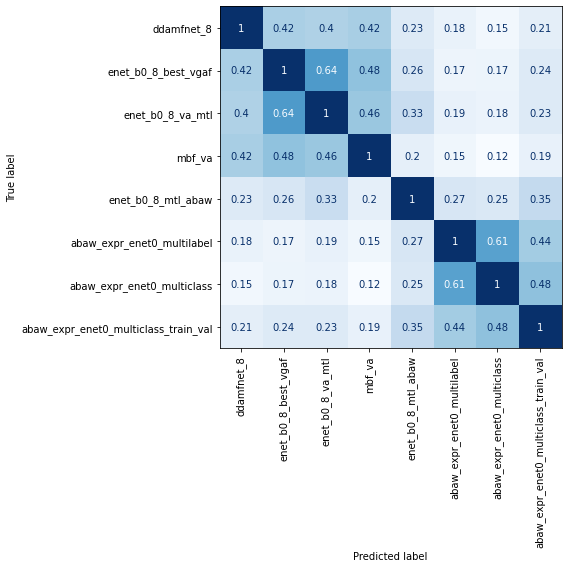

In [219]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(kappas,model2compound_labels.keys())
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(
        include_values=True,
        cmap=plt.cm.Blues,
        ax=ax,
        xticks_rotation="vertical",
        values_format=None,
        colorbar=False,
    )
plt.tight_layout()
plt.show()

# Save test results 

In [6]:
OUTPUT_DIR=DATA_DIR+'outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(OUTPUT_DIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_7/CE/outputs/


In [8]:
with open(DATA_DIR+'../test_set_examples/CER.txt', 'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

26146 ['image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry', '01/00001.jpg,', '01/00002.jpg,', '01/00003.jpg,', '01/00004.jpg,']


In [206]:
correct_filepaths=set()
for line in test_set_sample[1:]:
    correct_filepaths.add(line.split(',')[0])

filepaths=set()
for videoname in sorted(videoname2compound_scores):
    compound_scores=get_compound_scores(videoname,videoname2compound_scores)
    for i in range(len(compound_scores)):
        filepaths.add(videoname+'/'+get_names(i+1)+'.jpg')

print(correct_filepaths-filepaths,filepaths-correct_filepaths)

videos_with_new_frame,videos_with_extra_frame=[],[]
for filepath in (correct_filepaths-filepaths):
    videos_with_new_frame.append(filepath.split('/')[0])
for filepath in (filepaths-correct_filepaths):
    videos_with_extra_frame.append(filepath.split('/')[0])
    
print(videos_with_new_frame,videos_with_extra_frame)

{'24/00627.jpg', '29/00092.jpg', '28/00330.jpg', '51/00483.jpg', '05/00189.jpg', '56/00267.jpg', '16/00266.jpg', '40/00769.jpg', '43/00076.jpg', '44/00387.jpg', '33/00193.jpg'} {'10/00035.jpg', '09/00087.jpg', '22/00068.jpg', '45/00061.jpg'}
['24', '29', '28', '51', '05', '56', '16', '40', '43', '44', '33'] ['10', '09', '22', '45']


In [49]:
delta=50
print('freqs from paper:',freqs/freqs.sum())

for model_name in ['enet_b0_8_best_vgaf', 'mbf_va', 'enet_b0_8_mtl_abaw',
                  'abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass', 'abaw_expr_enet0_multiclass_train_val']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    compound_classes_counts=np.zeros(len(compound_classes))
    filepaths=set()
    with open(os.path.join(OUTPUT_DIR,model_name+'.txt'), 'w') as f:
        f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            max_i=len(compound_scores)
            if videoname in videos_with_extra_frame:
                max_i-=1
            for i in range(max_i):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+1)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')
            if videoname in videos_with_new_frame:
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+2)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')

    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


freqs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]
mbf_va set() [0.09783897 0.37464142 0.06567221 0.10066934 0.05136737 0.17467967
 0.135131  ] KL: 0.09872366077611314


### Submissions 

In [207]:
model_name='mbf_va'
with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)

In [210]:
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)

for delta in [10,50,100]:
    filepaths=set()
    compound_classes_counts=np.zeros(len(compound_classes))
    with open(os.path.join(OUTPUT_DIR,'1_'+model_name+'_'+str(delta)+'.txt'), 'w') as f:
        f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            max_i=len(compound_scores)
            if videoname in videos_with_extra_frame:
                max_i-=1
            for i in range(max_i):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+1)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')
            if videoname in videos_with_new_frame:
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+2)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')

    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


mbf_va set() [0.12009945 0.34779116 0.05894052 0.11336776 0.05729585 0.16389367
 0.13861159] KL: 0.07726130787213445
mbf_va set() [0.09783897 0.37464142 0.06567221 0.10066934 0.05136737 0.17467967
 0.135131  ] KL: 0.09872366077611314
mbf_va set() [0.0831899  0.39556321 0.06834959 0.10724804 0.05450373 0.17479442
 0.11635112] KL: 0.10517239972573313


In [211]:
videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)

for delta in [10,50,100]:
    filepaths=set()
    compound_classes_counts=np.zeros(len(compound_classes))
    with open(os.path.join(OUTPUT_DIR,'2_'+model_name+'_first_'+str(delta)+'.txt'), 'w') as f:
        f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            max_i=len(compound_scores)
            if videoname in videos_with_extra_frame:
                max_i-=1
            for i in range(max_i):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+1)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')
            if videoname in videos_with_new_frame:
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+2)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')

    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


mbf_va set() [0.11160834 0.32598967 0.06953528 0.10908395 0.06276535 0.17590361
 0.14511379] KL: 0.06859256204898498
mbf_va set() [0.0897686  0.35291643 0.0789826  0.09680627 0.0551922  0.18898451
 0.1373494 ] KL: 0.0927610995658489
mbf_va set() [0.07588449 0.37452668 0.07638172 0.09711226 0.05316504 0.19365079
 0.12927902] KL: 0.11445415020637041


In [216]:
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)

delta=50
for sigma in [100,1000,10000]:
    with open(os.path.join(OUTPUT_DIR,'3_'+model_name+'_'+str(delta)+'_'+str(sigma)+'.txt'), 'w') as f:
        f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=videoname2compound_scores[videoname]
            all_compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
            for i in range(frames_count):
                start,end=max(0,i-delta),min(frames_count,i+delta+1)
                k_sum=0
                max_faces_scores=np.zeros_like(all_compound_scores[i])
                for j in range(start,end):
                    if (j+1) in compound_scores:
                        k=math.exp(-(j-i)**2/sigma)
                        max_faces_scores+=k*compound_scores[j+1]
                        k_sum+=k
                if k_sum>0:
                    max_faces_scores/=k_sum
                else:
                    max_faces_scores=all_compound_scores[i]

                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+1)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')
            if videoname in videos_with_new_frame:
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+2)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')    
    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))

mbf_va set() [0.11805423 0.35037669 0.06183793 0.11193545 0.05178018 0.16581896
 0.14019657] KL: 0.08311755050945863
mbf_va set() [0.10271903 0.37179242 0.06428544 0.10233661 0.04237256 0.18149834
 0.1349956 ] KL: 0.11192533065650276
mbf_va set() [0.09965964 0.37821714 0.06390302 0.10271903 0.03908371 0.18509312
 0.13132433] KL: 0.1222483392875363


In [224]:
for model_name in ['mbf_va','abaw_expr_enet0_multilabel', 'abaw_expr_enet0_multiclass','abaw_expr_enet0_multiclass_train_val']:
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    for delta in [0,10]:
        for mean_function in [ARITHMETIC_MEAN,GEOMETRIC_MEAN,HARMONIC_MEAN]:
            filepaths=set()
            compound_classes_counts=np.zeros(len(compound_classes))
            videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll,mean_function)
            with open(os.path.join(OUTPUT_DIR,'4_'+model_name+'_'+str(delta)+'_agg_'+str(mean_function)+'.txt'), 'w') as f:
                f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
                for videoname in sorted(videoname2compound_scores):
                    compound_scores=get_compound_scores(videoname,videoname2compound_scores)
                    max_i=len(compound_scores)
                    if videoname in videos_with_extra_frame:
                        max_i-=1
                    for i in range(max_i):
                        i1=max(i-delta,0)
                        max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                        compound_index=np.argmax(max_faces_scores)
                        compound_classes_counts[compound_index]+=1
                        filepath=videoname+'/'+get_names(i+1)+'.jpg'
                        filepaths.add(filepath)
                        f.write(filepath +','+str(compound_index)+'\n')
                    if videoname in videos_with_new_frame:
                        compound_classes_counts[compound_index]+=1
                        filepath=videoname+'/'+get_names(i+2)+'.jpg'
                        filepaths.add(filepath)
                        f.write(filepath +','+str(compound_index)+'\n')

            compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
            print(model_name,delta,mean_function,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))

mbf_va 0 0 set() [0.13008223 0.32859055 0.05871103 0.12285332 0.06647543 0.15268694
 0.1406005 ] KL: 0.06035189095157949
mbf_va 0 1 set() [0.13918531 0.30070759 0.07515777 0.04631861 0.07473704 0.17364697
 0.1902467 ] KL: 0.10161662955222363
mbf_va 0 2 set() [0.14320138 0.28406961 0.07584624 0.037751   0.07649646 0.17647734
 0.20615797] KL: 0.12335288978533654
mbf_va 10 0 set() [0.12009945 0.34779116 0.05894052 0.11336776 0.05729585 0.16389367
 0.13861159] KL: 0.07726130787213445
mbf_va 10 1 set() [0.13964429 0.31642762 0.07393383 0.037904   0.06353031 0.18799006
 0.1805699 ] KL: 0.12780521850158844
mbf_va 10 2 set() [0.14587875 0.29898642 0.07408682 0.03193727 0.06965003 0.19020845
 0.18925225] KL: 0.13973069007677058
abaw_expr_enet0_multilabel 0 0 set() [0.01724995 0.67003251 0.0930197  0.04065787 0.0193536  0.11007841
 0.04960796] KL: 0.5452862763673841
abaw_expr_enet0_multilabel 0 1 set() [0.01740295 0.66253586 0.09393766 0.0399694  0.0195066  0.11841652
 0.04823102] KL: 0.54149016